# Navigation

This project entails training an agent to navigate and collect bananas in a large square world. The agent is given rewards as follows:

1. +1 for collecting yellow bananas
2. -1 for collecting purple bananas

The agent is expected to obtain as many rewards as possible. 

#### 1. Import Packages

The following imports are necessary in order to run the environment and train the agent. The agent built to solve this the given task is a DQN (Deep Q-Networks) which combines the uses of Q-learning and Deep Neural Networks. As a comparison to the performance, a variant of DQN - Double DQN is also implemented. 

In [23]:
from unityagents import UnityEnvironment

import numpy as np
import torch
from collections import deque

from dqnbanana import DQN

import matplotlib.pyplot as plt

#### 2. Setting Up Environment and DQN Agent

The environment is provided by UnityEnvironment called Banana.exe. This file is saved under the folder "Banana_Windows_x86_64" since all of the training is done on a Windows 64-bit machine. The graphics is disabled during the training. Next, the brain of the environment is set before resetting the environment prior to exploring and/or training. 

The following information, however, is important to note:

1. There are 4 discrete possible actions that the agent can take, namely:
    - `0` - Move forward
    - `1` - Move backward
    - `2` - Turn left
    - `3` - Turn right
2. There are 37 state-space including:
    a. Agent's velocity
    b. Ray-based perceptions of objects
    
DQN Agent is set up using learning rate of 0.0005, tau of 0.001 (for soft_update) and seed = 1. In the event that Double DQN is preferred to be implemented, set `DDQN = True`, otherwise `DQN = False`.

Both of these agents will have the following QNetwork architecture:

- `hidden_layer_1 = 128`, with `ReLU`
- `hidden_layer_2 = 64`, with `ReLU`
- `hidden_layer_3 = 32`, with `ReLU`
- `output_layer` has no activation function

In [2]:
env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe",
                       no_graphics=True)

brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=True)[brain_name]
action_size = brain.vector_action_space_size
state = env_info.vector_observations[0]
state_size = len(state)

dqn_agent = DQN(size_state=state_size, size_action=action_size, lr=0.0005,
                tau=0.001, DDQN=False, seed=1)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


#### 3. Define model_train() Function to Train the Agent

The following function is written to train the agent through a series of episodes. The total number of episodes is set to be 2000, with maximum of 1000 steps per episode. The epsilon specified for epsilon-greedy policy was experimented numerous times. The following parameters were found to be the most optimal:

1. epsilon = 1.0
2. mininum value of epsilon = 0.005
3. decay rate of epsilon = 0.97

The scores for each episode is recorded at the end of every loop. The stopping criteria of the agent trained is an average score of 13 or more for the past 100 consecutive episodes. This average score is stored within a list of mean_scores with maximum length of deque as 100. 

The function returns both the scores list and average scores list.

In [3]:
def model_train(num_episodes=2000, total_time=1000, epsilon=1.0, eps_min=0.005,
                eps_decay=0.97):
    '''Function to train the DQN/DDQN on the Unity environment
    
    Params:
        num_episodes (int)       : total number of episodes
        total_time (int)         : number of steps taken by the agent
        epsilon (float)          : constant for epsilon-greedy action
        eps_min (float)          : minimum value of epsilon
        eps_decay (float)        : decay rate of epsilon per episodes
        
    Return:
        scores (list)            : scores attained by the agent each episode
        avg_scores (list)        : agent's mean scores per episode (100 past)
    '''
    scores = []
    mean_scores = deque(maxlen=100)
    avg_scores = []
    epsilon = epsilon
    for episode in range(1, num_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for time in range(total_time):
            action = dqn_agent.select_action(state, epsilon).astype(int)
            env_info = env.step(action)[brain_name]
            state_ = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            dqn_agent.step(state, action, reward, state_, done)
            score += reward
            state = state_
            if done:
                break
        epsilon = max(eps_min, epsilon*eps_decay)
        mean_scores.append(score)
        scores.append(score)
        avg_100 = np.mean(mean_scores)
        avg_scores.append(avg_100)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode,
              avg_100), end="")
        if episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode,
                  avg_100))
        if avg_100 >= 13.0:
            print('\nEnvironment solved in {:d} episodes!'.format(episode))
            print('\tAverage Final Score: {:.2f}'.format(avg_100))
            if dqn_agent == True:
                torch.save(dqn_agent.qnet_local.state_dict(),
                            'saved_model/DQN.pth')
            else:
                torch.save(dqn_agent.qnet_local.state_dict(),
                            'saved_model/DDQN.pth')
            break
    return scores, avg_scores

After resetting the environment, the training can be started by executing the following cell.

In [4]:
env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]
dqn_scores, dqn_avg_scores = model_train()

Episode 100	Average Score: 0.99
Episode 200	Average Score: 6.20
Episode 300	Average Score: 9.73
Episode 379	Average Score: 13.12
Environment solved in 379 episodes!
	Average Final Score: 13.12


A vanilla-DQN with implementation of replay-buffer performs quite well. It only needs 379 episodes to attain the training criteria. It finishes the training with an average score of 13.12. The scores per episode as well as the average score per episode is plotted below. It can be seen that the agent learns consistently with increasing average scores most of the time. It is noted that the scores per episode are fluctuating since the underlying action taken by the agent can still be determined by random actions due to the epsilon-greedy policy.

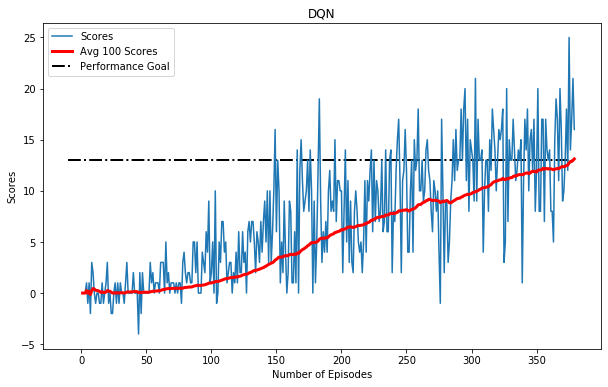

In [18]:
index = [i+1 for i in range(len(dqn_scores))]
plt.figure(figsize=(10,6))
plt.plot(index, dqn_scores, label='Scores')
plt.hlines(13, -10, len(dqn_scores)+1, colors = 'k', linestyle='dashdot',
           linewidth=2, label='Performance Goal')
plt.plot(index, dqn_avg_scores, 'r', linewidth=3, label='Avg 100 Scores')
plt.title('DQN')
plt.xlabel('Number of Episodes')
plt.ylabel('Scores')
plt.axis('tight')
plt.legend()
plt.savefig('figures/scores_episodes_dqn.png')
plt.show()

Next, a new agent is initialized using Double-DQN method. This is achieved by setting the DDQN argument as True. The other hyperparameters are left unchanged.

In [6]:
dqn_agent = DQN(size_state=state_size, size_action=action_size, lr=0.0005,
                tau=0.001, DDQN=True, seed=1)

In [7]:
env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]
ddqn_scores, ddqn_avg_scores = model_train()

Episode 100	Average Score: 0.90
Episode 200	Average Score: 5.42
Episode 300	Average Score: 7.90
Episode 400	Average Score: 10.88
Episode 452	Average Score: 13.00
Environment solved in 452 episodes!
	Average Final Score: 13.00


Surprisingly, even though Double-DQN should address the problem of DQN's tendecy to overshoot, the agent solved the environment in 452 episodes with average final score of 13.00. This is 73 more episodes in comparison to the regular DQN. Although it wasn't able to complete the environment as fast as the regular DQN, it is essential to note that this performance is still impressive. 

The plot of Double-DQN's rewards is shown below. It can be seen that the average scores' growth is not as consistent as the regular DQN. Especially around episodes 250-320.

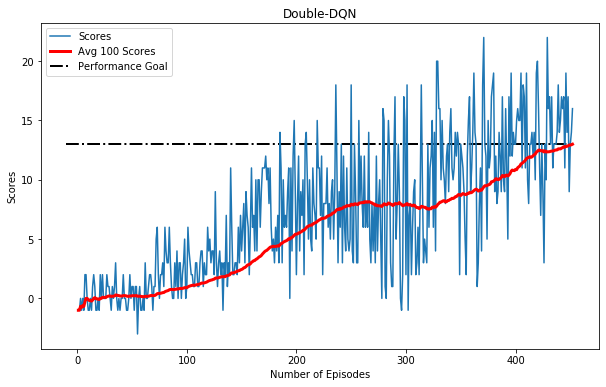

In [17]:
index = [i+1 for i in range(len(ddqn_scores))]
plt.figure(figsize=(10,6))
plt.plot(index, ddqn_scores, label='Scores')
plt.hlines(13, -10, len(ddqn_scores)+1, colors = 'k', linestyle='dashdot', 
           linewidth=2, label='Performance Goal')
plt.plot(index, ddqn_avg_scores, 'r', linewidth=3, label='Avg 100 Scores')
plt.title('Double-DQN')
plt.xlabel('Number of Episodes')
plt.ylabel('Scores')
plt.axis('tight')
plt.legend()
plt.savefig('figures/scores_episodes_ddqn.png')
plt.show()

#### 4. Discussion and Observations

From the results above, it is concluded that the DQN outperforms DDQN, although not by a large margin. The plots available suggest that DQN has a better consistency in terms of learning from the environment. Although this is a substantial comparison between the performance of the two methods, there is another aspect of this project that needs to be addressed. This important aspect is the parameter of the DQN and DDQN. 

In the process of completing the project, numerous combinations of hyperparameters were implemented for DQN. Among 20 or so combinations, this hyperparameters were found to be the most optimal:

1. epsilon = 1.0
2. eps_min = 0.005
3. eps_decay = 0.97
4. gamma = 0.99
5. tau = 0.001
6. learning rate = 0.0005
7. Deep QNetwork:
   - hidden_layer_1 = 128, with ReLU
   - hidden_layer_2 = 64, with ReLU
   - hidden_layer_3 = 32, with ReLU
   - output_layer has no activation function
8. targetUpdateNet = 4
9. seed = 1

These hyperparameters can be easily tweaked and resulting in the Double-DQN outperforming the regular DQN. Although with the nature of complexity, the DQN is slightly easier to implement and therefore would still most likely to be the more efficient option.

#### 5. Watch Smart Agent Plays!

The following cell provides the simulation of how a smart agent nagivates through the environment.

In [36]:
env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe",
                       no_graphics=False, worker_id=1, seed=1) # enable graphics

dqn_agent.qnet_local.load_state_dict(torch.load('saved_model/DQN.pth')) 
# Change DQN to DDQN for Double-DQN

for i in range(3):
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]
    for j in range(100):
        action = dqn_agent.select_action(state, eps=0.).astype(int)
        env_info = env.step(action)[brain_name]
        state = env_info.vector_observations[0]   
        done = env_info.local_done[0]
        if done:
            break 
env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 
